# AI - Keras Neural Network

La spécificité de keras est quelle utilise TensorFlow et Theano comme "engine". Cette librairie permet de se concentrer sur l'aspect design et training et les specificités liées au tensor sont laissé à tensorflow et theano.

# Import

In [36]:
import  numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import models
from keras import layers
from keras.datasets import imdb, reuters
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# Sommaire

[I. Designing a neural network](#Partie1)

[II. Training a binary and multiclass classifier](#Partie2)
- [II.1. Binary](#Partie2.1) 
- [II.2. Multiclass](#Partie2.2) 

[III. Training a regressor](#Partie3)

[IV. Visualizing training and making predictions](#Partie4)
- [IV.1. Visualizing training](#Partie4.1) 
- [IV.2. Making predictions](#Partie4.2) 

[V. Reduce overfitting](#Partie5)
- [V.1. With weight regularization](#Partie5.1) 
- [V.2. With early stopping](#Partie5.2)
- [V.3. With dropout](#Partie5.3) 

[VI. Saving model training progress](#Partie6)

[VII. k-fold cross-validation and tunning a neural network](#Partie7)
- [VII.1. K-fold cross validation](#Partie7.1) 
- [VII.2. Tuning neural networks](#Partie7.2)

[VIII. Visualizing neural networks](#Partie8)

[IX. Classifying images](#Partie9)
- [IX.1. Image classification](#Partie9.1) 
- [IX.2. Improving performance with image augmentation](#Partie9.2)

[X. Classifying text](#Partie10)


## I. Designing a neural network<a class="anchor" id="Partie1"></a>

Tout d'abord les données sont preprocessées selon leur type (si numérique alors on utilise standardscaler)

Les reseaux de neurones consistent en des couches d'unité (neurone). Pour construire ici un reseau feed forward on doit faire plusieurs choix pour l'architecture et le processus d'entrainement. Il faut tout d'abord se rappeler que chaque unit (ie neurone) recoit :
- un certain nombe d'inputs
- toutes les inputs sont pondérés par un paramètre
- on fait la combinaison linéaire de toutes les inputs pondérés et d'un biais (1 en général)
- on y applique ensuite une fonction d'activation
- on envoie l'output a la couche suivante

1/ De manière générale: plus il y a de neurones sur une couche plus le reseau sera capable d'apprendre des pattern complexes mais plus le reseau est susceptible de surappendre. On doit d'abord chosir la fonction d'activation (relu est un bon choix si la somme pondérée est inférieur à 0 alors la fonction renvoie 0 sinon elle renvoie la somme)

2/ On doit ensuite définir le nombre de couche cachée à ajouter à l'architecture. Plus il y a de couche plus le reseau peut appendre des relations complexes mais avec un coût sur la complexité.
 
3/On doit ensuite définir la couche d'activation pour la dernière couche. Cela depend du but du reseau:
- pour une classification binaire on utilisera sigmoide
- pour une classifcation multiclass on utilisera softmax
- pour une regression on utilisera pas d'activation (ie linéaire)

4/ Dans un 4eme temps on définit la loss function (qui mesure à quel point les valeurs prédites sont poches des vrais valeurs)
- binary classification: binary cross entropy
- multiclass classification: categorical cross entropy
- regression: mse

5/ On définit ensuite "l'optimizer" qui est note stratégie pour trouver les meilleurs paramètres pou poduire une loss minimale. les choix communs sont: stochastic gradient descent, with momentum, rms propagation, adaptative moment...

6/ On selectionne les metriques de performance de notre algorithme.

Keras permet de construire un reseau avec sequential qui va juxtaposer chaque couche. Dans notre reseau on a crée un reseau à 2 couches (on ne compte pas la couche d'entrée car elle n'a pas de poid). Les couches sont "dense" (qui correspond à des couches fully connected ie tous les neurones de la couche précédente sont connectés au neurones de la couche suivante). Units=16 signifie qu'il y a 16 neurones sur la couche. Dans Keras la première couche cachée doti comporter l'argument "input_shape" qui est la dimension des features (ie leur nombre). (10,) signifie que chaque observation a 10 features. ici on a designé un reseau pour une classification binaire donc il y a une seule sortie avec activation sigmoide qui sera entre 0 et 1 qui correspond à la probabilité d'obtenir la classe 1.

In [37]:
network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(10,))) #ajout d'une fully connected layer avec Relu
network.add(layers.Dense(units=16,activation="relu")) #ajout d'une fully connected layer avec Relu
network.add(layers.Dense(units=1,activation="sigmoid")) #ajout d'une fully connected layer avec sigmoide

network.compile(loss="binary_crossentropy", # loss de cross entropy pour pb de classification
                optimizer="rmsprop", # propagation avec root mean square 
                metrics=["accuracy"]) #accuracy comme metrique de performance

## II. Training a binary and multiclass classifier<a class="anchor" id="Partie2"></a>

### II.1. Binary<a class="anchor" id="Partie2.1"></a>

Dans cet entrainement d'un modele de classification binaire on utilise les données: de movie review (text) qui sont catégorisées en bonne (1) ou mauvaise (0). On convertit les reviews en 5000 features binaire qui indique ou non la présence des 1000 mots les plus fréquents (en one-hot encoder: si mot existe 1 sinon 0). Ces one hot vecteurs correspondent au set de train et test avec leur label correspondant.

On utilise la fonction fit de Keras pour entrainer le modèle:
- 2 premiers paramètres: features et target vecteurs du set de train
- paramètre epoch: nombre d'itération de train sur tout le set de train (ie tous les batchs)
- verbose 0,1,2 : donne des informations plus ou moins détaillé sur les epochs
- batch_size: taille des batchs pendant les epoch
- test data

La méthode fit de Keras renvoie un object qui contient les valeurs de loss et les metriques de performance demandées

In [38]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=3, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/3
250/250 [==============================] - 2s 4ms/step - loss: 0.4099 - accuracy: 0.8161 - val_loss: 0.3426 - val_accuracy: 0.8536
Epoch 2/3
250/250 [==============================] - 1s 4ms/step - loss: 0.3235 - accuracy: 0.8640 - val_loss: 0.3304 - val_accuracy: 0.8592
Epoch 3/3
250/250 [==============================] - 1s 4ms/step - loss: 0.3143 - accuracy: 0.8698 - val_loss: 0.3278 - val_accuracy: 0.8592


### II.2. Multiclass<a class="anchor" id="Partie2.2"></a>

La différence entre le classifier ci-dessus et dessous est la catégorisation en 46 classe plutôt que une classe 0 et une classe 1 il doit donc y avoir 46 noeuds sur la dernière couche par rapport à un noeud sur la première. Le vecteur de target doit donc également être encodé en one-hot, c'est à dire chaque ligne de ces matrices contient 46 élements avec des 0 partout sauf au numéro de la classe correspondante.
Un élément important à prendre en compte est l'utilisation de la fonction d'activation softmax sur la dernière couche qui va permettre d'avoir une somme des issues égale à 1 (correspondant donc au probabilité d'occurence de chaque classe).

In [39]:
np.random.seed(0) #on confidure la random seed
number_of_features=5000 #nombre de features dans le set

#on utilise le set reuters pour créer le set de train et test
data=reuters.load_data(num_words=number_of_features) 
(data_train,target_train),(data_test,target_test)=data

# On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 5000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

# on one-hot encode le vecteur de target
target_train=to_categorical(target_train)
target_test=to_categorical(target_test)


network=models.Sequential() #start neural network

network.add(layers.Dense(units=100,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=100,activation="relu"))
network.add(layers.Dense(units=46,activation="softmax")) #units = nombre de classe dans le set

network.compile(loss="categorical_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=3, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data

Epoch 1/3
90/90 [==============================] - 2s 14ms/step - loss: 1.5281 - accuracy: 0.6729 - val_loss: 1.1204 - val_accuracy: 0.7502
Epoch 2/3
90/90 [==============================] - 1s 13ms/step - loss: 0.7950 - accuracy: 0.8250 - val_loss: 0.9481 - val_accuracy: 0.7801
Epoch 3/3
90/90 [==============================] - 1s 13ms/step - loss: 0.5079 - accuracy: 0.8884 - val_loss: 0.8704 - val_accuracy: 0.8045


## III. Training a regressor<a class="anchor" id="Partie3"></a>

Dans les cas précédents nous appliquions des fonctions activation sur la dernière couche. Dans le cas d'une regression on utilise une activation "linéaire" c'est à dire on utilise pas de fonction d'activation on renvoie directement le résultat de la combinaison linéaire de la dernière couche de neurones. On utilise ici une loss approriée comme la mse ou la mae selon la distribution des valeurs et notamment des anomalies pour leur donner plus ou moins de poid..

In [40]:
np.random.seed(0) #on confidure la random seed

#on génere les matrices de features et de target
features,target=make_regression(n_samples=10000,
                                n_features=3,
                                n_informative=3,
                                n_targets=1,
                                noise=0,
                                random_state=0)

# On divise notre matrice et nos targets en train et test
features_train, features_test, target_train,target_test=train_test_split(features, target, test_size=0.33, random_state=0)

network=models.Sequential() #start neural network

network.add(layers.Dense(units=32,activation="relu",input_shape=(features_train.shape[1],))) 
network.add(layers.Dense(units=32,activation="relu"))
network.add(layers.Dense(units=1))

network.compile(loss="mse", 
                optimizer="RMSprop", 
                metrics=["mse"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=50, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data




Epoch 1/50
67/67 [==============================] - 1s 5ms/step - loss: 17370.6191 - mse: 17370.6191 - val_loss: 17791.0059 - val_mse: 17791.0059
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 16634.7871 - mse: 16634.7871 - val_loss: 16710.4590 - val_mse: 16710.4590
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 15253.0352 - mse: 15253.0352 - val_loss: 14869.9717 - val_mse: 14869.9717
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 13108.6738 - mse: 13108.6738 - val_loss: 12225.5879 - val_mse: 12225.5879
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 10227.8320 - mse: 10227.8320 - val_loss: 8932.6895 - val_mse: 8932.6895
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 6846.4551 - mse: 6846.4551 - val_loss: 5367.4854 - val_mse: 5367.4854
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 3637.7449 - mse: 3637.7449 - val_loss: 2392.7490 - val_mse

## IV. Visualizing training and making predictions<a class="anchor" id="Partie4"></a>

In [41]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=30, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 0.4308 - accuracy: 0.8066 - val_loss: 0.3411 - val_accuracy: 0.8560
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.8641 - val_loss: 0.3482 - val_accuracy: 0.8515
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3150 - accuracy: 0.8705 - val_loss: 0.3266 - val_accuracy: 0.8611
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3062 - accuracy: 0.8718 - val_loss: 0.3364 - val_accuracy: 0.8562
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8772 - val_loss: 0.3311 - val_accuracy: 0.8590
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2864 - accuracy: 0.8807 - val_loss: 0.3336 - val_accuracy: 0.8597
Epoch 7/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2753 - accuracy: 0.8866 - val_loss: 0.3386 - val_accuracy: 0.8565
Epoch 

### IV.1. Visualizing training<a class="anchor" id="Partie4.1"></a>

Pendant l'entrainement du resueau de neurones les 2 erreurs de test et de train vont diminuer. Mais à un certain point le réseau va sur-apprendre le set de train et se se "rémorer" celui-ci. C'est alors que l'on voit une divergence de croissance entre l'erreur de training et celle de test.  Il faut donc arreter l'entrainement avant cet instant là pour avoir une erreur de validation minmale.

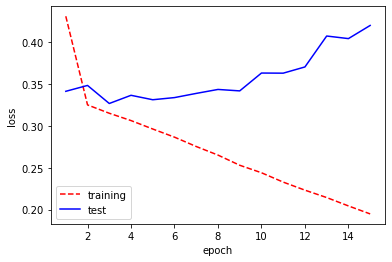

In [48]:
# on recupère la loss de training et de validation et le nombre d'epoch
training_loss=history.history["loss"]
test_loss=history.history["val_loss"]
epoch_count=range(1,len(training_loss)+1)

# visualisation de la loss
plt.plot(epoch_count[:15],training_loss[:15],"r--")
plt.plot(epoch_count[:15],test_loss[:15],"b-")
plt.legend(["training","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

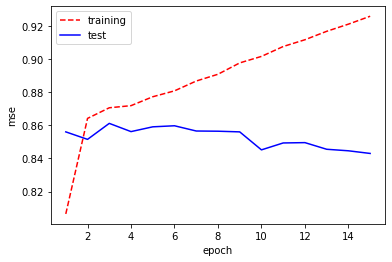

In [47]:
training_acc=history.history["accuracy"]
test_acc=history.history["val_accuracy"]

# visualisation de l'accuracy
plt.plot(epoch_count[:15],training_acc[:15],"r--")
plt.plot(epoch_count[:15],test_acc[:15],"b-")
plt.legend(["training","test"])
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

### IV.2. Making predictions<a class="anchor" id="Partie4.2"></a>

Une fois le réseau entrainé on utilise la fonction predict pour prédire de nouvelle valeur avec le reseau. si le reseau prédit l'issu d'une classification binaire (notre cas) le résultat est la probabilité d'obtenir 1. Si c'est une multiclassification on a alors la probabilité de toutes les classes et on peut obtenir la classe avec la probabilité maximum en utilisant la fonction argmax. Enfin si c'est une régression on va avoir la valeur réelle prédite.

In [42]:
predicted_target=network.predict(features_test)
predicted_target[4]

array([0.99999017], dtype=float32)

## V. Reduce overfitting<a class="anchor" id="Partie5"></a>

### V.1. With weight regularization<a class="anchor" id="Partie5.1"></a>

### V.2. With early stopping<a class="anchor" id="Partie5.2"></a>

### V.3. With dropout<a class="anchor" id="Partie5.3"></a>

## VI. Saving model training progress<a class="anchor" id="Partie6"></a>

## VII. k-fold cross-validation and tunning a neural network<a class="anchor" id="Partie7"></a>

### VII.1. K-fold cross validation<a class="anchor" id="Partie7.1"></a>

### VII.2. Tuning neural networks<a class="anchor" id="Partie7.2"></a>

## VIII. Visualizing neural networks<a class="anchor" id="Partie8"></a>

## IX. Classifying images<a class="anchor" id="Partie9"></a>

### IX.1. Image classification<a class="anchor" id="Partie9.1"></a>

### IX.2. Improving performance with image augmentation<a class="anchor" id="Partie9.2"></a>

## X. Classifying text<a class="anchor" id="Partie10"></a>